In [1]:
%pylab inline

import gym
import tensorflow as tf

from tensorflow import keras
from gym import wrappers
from collections import deque

Populating the interactive namespace from numpy and matplotlib


In [4]:
import io
import base64
from IPython.display import HTML

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))

In [2]:
input_shape = [4]
n_outputs = 2
model = keras.models.Sequential([
    keras.layers.Dense(32, activation='elu', input_shape=input_shape),
    keras.layers.Dense(32, activation='elu'),
    keras.layers.Dense(n_outputs)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [3]:
def epsilon_greedy_policy(state, epsilon=0):
    # Introduce random actional with probability epsilon
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        # Return maximum predicted Q-value, Q_values = [Q_action_1, Q_action_2]
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])
    
def sample_experiences(batch_size):
    # Select 'batch_size' random experiences from queue
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    # Reslice into separate arrays for each component of the experience
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

def play_one_step(env, state, epsilon):
    # Generate an action and execute it
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    # Add this experience to the queue
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

def training_step(batch_size):
    # Sample experiences
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    # Predict and select the maximum Q-values from each experience
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    # Target Q-value
    target_Q_values = (rewards + (1- dones) * discount_factor * max_next_Q_values)
    # Ignore less-than-optimal predicted Q-values for each experience 
    mask = tf.one_hot(actions, n_outputs)
    # Compute gradient
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [4]:
replay_buffer = deque(maxlen=2000)

In [5]:
batch_size = 32
discount_factor = 0.95
optimizer = keras.optimizers.Adam(lr=1e-3)
loss_fn = keras.losses.mean_squared_error

In [24]:
env = gym.make('CartPole-v1')
#total_rewards = []
for episode in range(600):
    obs = env.reset()
    total = 0
    for step in range(200):
        epsilon = 0.0 #max(1 - episode/500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        total += reward
        if done:
            total_rewards.append(total)
            break
    if episode > 50:
        training_step(batch_size)

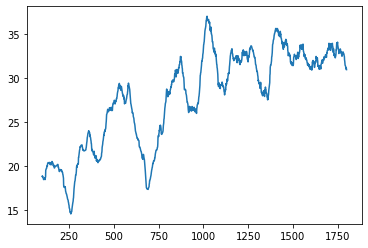

In [29]:
import pandas
plot(pandas.Series(total_rewards).rolling(100).mean())

In [23]:
env = wrappers.Monitor(env, "./gym-results", force=True)
obs = env.reset()
done = False
total_reward = 0
while not done:
    Q_values = model.predict(obs.reshape(1,4))
    obs, reward, done, info = env.step(np.argmax(Q_values[0]))
    total_reward += reward
env.close()
print('lasted %d steps'%total_reward)

lasted 79 steps
